# Урок 4. Обучение моделей с помощью градиентного спуска

Мы помним, что в случае многомерной линейной регрессии (когда количество фичей $m$) аналитическое решение имеет вид
$$
\overline{w} = \left(X^TX\right)^{-1}X^T\overline{y}
$$

Где $X$ - т.н. матрица объекты-признаки размерности *количество объектов* x *количество признаков*.

У аналитического решения есть ряд недостатков
* Вычислительная сложность из-за матричного перемножения $O(n^3)$, где $n$ - размерность матрицы. При увеличении размерности матрицы в 10 раз сложность вычислений увеличивается в $10^3=1000$ раз
* Неустойчивость вычислений - пытаемся найти обратную матрицу, которая может не существовать, в этом случае в алгоритме нахождения обратной матрицы возникает деление на ноль

С неустойчивостью вычислений, например, связано предупреждение **LinAlgWarning:** которое мы видели в первом уроке. Пример такой матрицы:
$$
X^TX = 
\left[
\begin{array}{cc}
2 & 1 \\
4 & 2 
\end{array}
\right]
$$

Допустим, хотим вычислить коэффициенты аналитически. Если попытаемся найти обратную матрицу $(X^TX)^{-1}$, мы получим сообщение об ошибке:

In [1]:
import numpy as np
# матрица из примера
X = np.array([[2,1],[4,2]])
# пытаемся найти обратную
np.linalg.inv(X)

LinAlgError: Singular matrix

Это очень печально - значит, мы не всегда можем применять аналитическую формулу $\overline{w} = \left(X^TX\right)^{-1}X^T\overline{y}$ для нахождения коэффициентов $\overline{w}$ Как же быть, если задачу решать все равно надо?

Решение этих проблем нашли математики - давайте вычислять коэффициенты линейной регрессии не аналитически, а с помощью приближённых численных методов. Тогда не надо будет перемножать матрицы или находить обратные матрицы. Самый простой и эффективный из этих методов называется методом *градиентного спуска*. Суть метода состоит в обновлении параметров модели $w$ по маленьким шажкам (вместо того, чтобы находить их сразу) - это и есть градиентный спуск.

Каждый такой шажок назвается "итерация".

Мы знаем, что коэффициенты обучаются при помощи минимизации функции ошибок:

$$
L(y,w) = \sum_{i=1}^{N}\left(y_i - \hat{y_i}\right)^2
$$

Эта функция квадратичная - следовательно, имеет форму параболы. Минимум параболы соответствует минимуму ошибки - давайте как-то понемногу "подкручивать" параметры, чтобы по шажкам спуститься в точку, где ошибка будет минимальной - в этой точке и находятся параметры $w$, которые мы ищем. Правила обновления весов должны быть очень простыми и не содержать матричных перемножений

![grad_descent_single_measure](https://248006.selcdn.ru/public/Data-science-3/img/grad_descent_single_measure.png)

В трёхмерном случае картинка более красивая - мы движемся как бы ландшафту и хотим найти самую нижнюю точку на этом ландшафте:

![grad_descent_single_measure](https://248006.selcdn.ru/public/Data-science-3/img/grad_descent_multi_measure.png)

В библиотеке sklearn уже есть класс, в котором реализована логика такого путешествия - это класс `sklearn.linear_model.SGDRegressor`. Давайте посмотрим, как он работает на примере нашей выборки из прошлого урока - начнём с загрузки исходных данных

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# для регрессии
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
%matplotlib inline

data = pd.read_csv('data/non_linear.csv', sep=',')
data = data[(data.x_train > 1) & (data.x_train < 5)].copy()

X = data['x_train'].values.reshape(-1, 1) # превращаем X из простого массива в вектор-столбец
y = data['y_train'].values

# разбиваем на трейн и валидацию
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

data.head()

,x_train,y_train
5,1.182421,1.860341
6,1.251605,1.878928
7,1.270474,2.430015
8,1.402553,2.327856
9,1.427711,2.203649


Запустим шажки градиентного спуска (те самые итерации). Для градиентного спуска мы используем готовый класс SGDRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html . Класс принимает следующие параметры


* learning_rate='constant' используем самую простую модификацию спуска из нескольких возможных (см. документацию)
* eta0 - шаг градиентного спуска, в формуле мы его обозначали буквой $\alpha$
* fit_intercept - чтобы обучить коэффициент при "свободном члене" линейной регрессии (см. "Линейная регрессия. Часть 1")
* random_state - этот параметр встречали ранее в этом модуле, он нужен для воспроизводимости вычислений

Функция `partial_fit()`, которую мы вызываем в коде, делает одну итерацию градиентного спуска.

По оси $oX$ отложим количество итераций, а по оси $oY$ - значение метрики качества *MSE*, которое получили на  валидации

Итарации остановлены на шаге 208


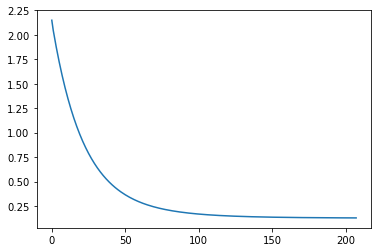

In [3]:
sgd_regressor = SGDRegressor(learning_rate='constant', eta0=0.009, fit_intercept=True, random_state=42)
w_current, epsilon = np.random.random(2), 0.0001
weight_evolution, mse_evolution = [], [] # изменения весов и ошибка на валидации
for step in list(range(800)):
    sgd_regressor = sgd_regressor.partial_fit(X_train, y_train)
    weight_evolution.append(distance.euclidean(w_current, sgd_regressor.coef_))
    if weight_evolution[-1]<epsilon:
        print("Итарации остановлены на шаге %d" % step); break
    mse_evolution.append(mean_squared_error(y_valid, sgd_regressor.predict(X_valid)))
    w_current = sgd_regressor.coef_.copy()
plt.plot(range(step), mse_evolution)

**Практическое задание** очевидно, что чем больше шаг градиентного спуска (параметр *eta0* класса *SGDRegressor*), тем быстрее мы придём к оптимальным значениям. Используя код выше, поиграйтесь с параметром *eta0* и добейтесь , чтобы градиентный спуск закончился быстрее, чем за 200 шагов.

Сколько шагов у вас получилось? Какое качество *MSE* у Вашего решения?

Итарации остановлены на шаге 191, MSE=0.131872


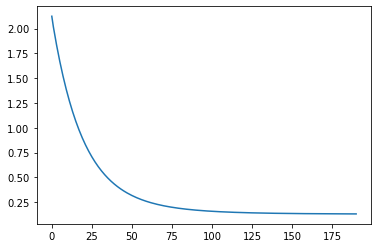

In [4]:
# -- ВАШ КОД ТУТ
eta0 = 0.01
sgd_regressor = SGDRegressor(learning_rate='constant', eta0=eta0, fit_intercept=True, random_state=42)
w_current, epsilon = np.random.random(2), 0.0001
weight_evolution, mse_evolution = [], [] # изменения весов и ошибка на валидации
for step in list(range(800)):
    sgd_regressor = sgd_regressor.partial_fit(X_train, y_train)
    weight_evolution.append(distance.euclidean(w_current, sgd_regressor.coef_))
    if weight_evolution[-1]<epsilon:
        print("Итарации остановлены на шаге %d, MSE=%f" % (step, mean_squared_error(y_valid, sgd_regressor.predict(X_valid))) ); break
    mse_evolution.append(mean_squared_error(y_valid, sgd_regressor.predict(X_valid)))
    w_current = sgd_regressor.coef_.copy()
plt.plot(range(step), mse_evolution)

Визуализируем решение на графике

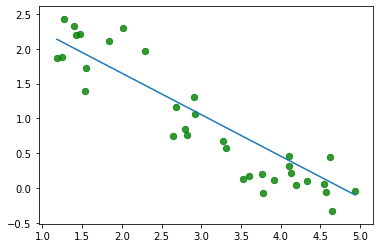

In [5]:
x_linspace = np.linspace(data['x_train'].min(), data['x_train'].max(), num=100)

y_linspace= sgd_regressor.predict(x_linspace.reshape(-1,1))

plt.plot(x_linspace, y_linspace)
plt.scatter(data.x_train, data.y_train, 40, 'g', 'o', alpha=0.8, label='data')

plt.show()

Готово! Мы получили решение задачи линейной регрессии, обучив параметры линейной регресии небольшими "шажками". Мы не использовали сложных матричных вычислений - тем не менее получили линию регрессии, которая лежит в середине облака точек. Когда стоит использовать градиентный спуск в реальных задачах?

* когда данных очень много - в этом случае компьютер может не справится с перемножением матриц
* когда нужно контролировать точность обучения - остановить итерации можно в любой момент (не дожидаясь, пока дойдем до "идеальных" значений)

Когда не стоит применять градиентный спуск? Когда данных мало - в этом случае лучше воспользоваться классами *Ridge* и *Lasso*.